In [4]:
from Data.build_dataset import build_dataset
import matplotlib.pyplot as plt 
import torch
import numpy as np 
import cv2 
from Data.dataset import VOCDetection
def generate_txty_me(gt_label,height,width,s): #gt_label [cxcywhc] normalized 
    cx,cy,w,h=gt_label[:-1]
    cx_s=cx/s*width #cx n -> cx s 
    cy_s=cy/s*height #cy n -> cy s 

    grid_x=int(cx_s)
    grid_y=int(cy_s)

    tx=cx_s-grid_x
    ty=cy_s-grid_y

    tw=np.log(width*w)
    th=np.log(height*h)
    scale=2-h*w

    return grid_x,grid_y,tx,ty,tw,th,scale


def gt_creator_me(input_size,stride,label_list=[]):
    h,w=input_size,input_size
    hs=h//stride
    ws=w//stride
    batch_size=len(label_list)
    s=stride
    gt=np.zeros([batch_size,ws,hs,1+4+1+1])
    for batch_id in range(batch_size):
        for gt_label in label_list[batch_id]:
            gt_class=int(gt_label[-1])
            result=generate_txty_me(gt_label,h,w,s)
            if result:
                grid_x,grid_y,tx,ty,tw,th,scale=result
                gt[batch_id,grid_x,grid_y,0]=1
                gt[batch_id,grid_x,grid_y,1]=gt_class
                gt[batch_id,grid_x,grid_y,2:6]=np.array([tx,ty,tw,th])
                gt[batch_id,grid_x,grid_y,6]=scale
    gt=gt.reshape(batch_size,-1,1+4+1+1)
    return torch.tensor(gt).float() 


In [3]:
%cd ..

c:\Users\faroo\yolov1_project\yolov1


In [5]:
dataset=VOCDetection(root=r'Data\VOCdevkit',
                         img_size=416,
                         mode='val'
                         )

In [6]:
def xywhn2xyxy(x, w=416, h=416, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = w * (x[..., 0] - x[..., 2] / 2) + padw  # top left x
    y[..., 1] = h * (x[..., 1] - x[..., 3] / 2) + padh  # top left y
    y[..., 2] = w * (x[..., 0] + x[..., 2] / 2) + padw  # bottom right x
    y[..., 3] = h * (x[..., 1] + x[..., 3] / 2) + padh  # bottom right y
    return y
def int_(x,y):
  return int(x),int(y)
def draw_grid(img, grid_shape=[13,13], color=(0, 255, 0), thickness=1):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv2.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv2.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

In [7]:
bbxoes=xywhn2xyxy(dataset[0][1][:,:-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


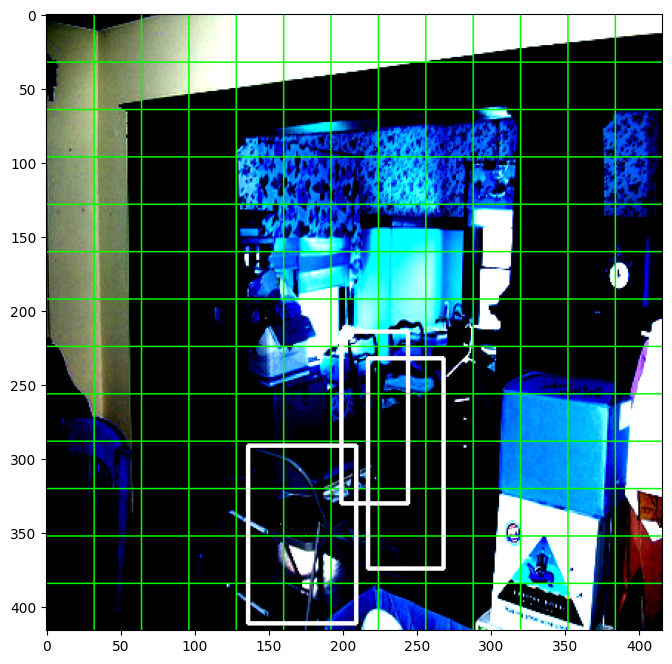

In [130]:
i,j=dataset[0]
img=np.array(i.permute(1,2,0))
bbxoes=xywhn2xyxy(j[:,:-1])
img=draw_grid(img)
plt.figure(figsize=(16,8))
n=0
for l in bbxoes:
  x1,x2=l[0],l[2]
  y1,y2=l[1],l[3]
  z=(np.random.randint(255),np.random.randint(255),np.random.randint(255))
  cv2.rectangle(img,int_(x1,y1),int_(x2,y2),z,2,0)
  # cv2.putText(img,f'{l}',(0,0+n),cv2.FONT_HERSHEY_SIMPLEX,.6,z,2,cv2.LINE_AA)
  n+=20
plt.imshow(img)

In [8]:
import cv2
import numpy as np
import types
from numpy import random


def intersect(box_a, box_b):
    max_xy = np.minimum(box_a[:, 2:], box_b[2:])
    min_xy = np.maximum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_xy - min_xy), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]


def jaccard_numpy(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: Multiple bounding boxes, Shape: [num_boxes,4]
        box_b: Single bounding box, Shape: [4]
    Return:
        jaccard overlap: Shape: [box_a.shape[0], box_a.shape[1]]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1]))  # [A,B]
    area_b = ((box_b[2]-box_b[0]) *
              (box_b[3]-box_b[1]))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


class Compose(object):
    """Composes several augmentations together.
    Args:
        transforms (List[Transform]): list of transforms to compose.
    Example:
        >>> augmentations.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels


class ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels


class Normalize(object):
    def __init__(self, mean=None, std=None):
        self.mean = np.array(mean, dtype=np.float32)
        self.std = np.array(std, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image /= 255.
        image -= self.mean
        image /= self.std

        return image, boxes, labels


class ToAbsoluteCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] *= width
        boxes[:, 2] *= width
        boxes[:, 1] *= height
        boxes[:, 3] *= height

        return image, boxes, labels


class ToPercentCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] /= width
        boxes[:, 2] /= width
        boxes[:, 1] /= height
        boxes[:, 3] /= height

        return image, boxes, labels


class ConvertColor(object):
    def __init__(self, current='BGR', transform='HSV'):
        self.transform = transform
        self.current = current

    def __call__(self, image, boxes=None, labels=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        else:
            raise NotImplementedError
        return image, boxes, labels


class Resize(object):
    def __init__(self, size=640):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size, self.size))
        return image, boxes, labels


class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image, boxes, labels


class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image, boxes, labels


class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image, boxes, labels


class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image, boxes, labels


class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image, boxes, labels


class RandomSampleCrop(object):
    """Crop
    Arguments:
        img (Image): the image being input during training
        boxes (Tensor): the original bounding boxes in pt form
        labels (Tensor): the class labels for each bbox
        mode (float tuple): the min and max jaccard overlaps
    Return:
        (img, boxes, classes)
            img (Image): the cropped image
            boxes (Tensor): the adjusted bounding boxes in pt form
            labels (Tensor): the class labels for each bbox
    """
    def __init__(self):
        self.sample_options = (
            # using entire original input image
            None,
            # sample a patch s.t. MIN jaccard w/ obj in .1,.3,.4,.7,.9
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            # randomly sample a patch
            (None, None),
        )

    def __call__(self, image, boxes=None, labels=None):
        height, width, _ = image.shape
        while True:
            # randomly choose a mode
            sample_id = np.random.randint(len(self.sample_options))
            mode = self.sample_options[sample_id]
            if mode is None:
                return image, boxes, labels

            min_iou, max_iou = mode
            if min_iou is None:
                min_iou = float('-inf')
            if max_iou is None:
                max_iou = float('inf')

            # max trails (50)
            for _ in range(50):
                current_image = image

                w = random.uniform(0.3 * width, width)
                h = random.uniform(0.3 * height, height)

                # aspect ratio constraint b/t .5 & 2
                if h / w < 0.5 or h / w > 2:
                    continue

                left = random.uniform(width - w)
                top = random.uniform(height - h)

                # convert to integer rect x1,y1,x2,y2
                rect = np.array([int(left), int(top), int(left+w), int(top+h)])

                # calculate IoU (jaccard overlap) b/t the cropped and gt boxes
                overlap = jaccard_numpy(boxes, rect)

                # is min and max overlap constraint satisfied? if not try again
                if overlap.min() < min_iou and max_iou < overlap.max():
                    continue

                # cut the crop from the image
                current_image = current_image[rect[1]:rect[3], rect[0]:rect[2],
                                              :]

                # keep overlap with gt box IF center in sampled patch
                centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0

                # mask in all gt boxes that above and to the left of centers
                m1 = (rect[0] < centers[:, 0]) * (rect[1] < centers[:, 1])

                # mask in all gt boxes that under and to the right of centers
                m2 = (rect[2] > centers[:, 0]) * (rect[3] > centers[:, 1])

                # mask in that both m1 and m2 are true
                mask = m1 * m2

                # have any valid boxes? try again if not
                if not mask.any():
                    continue

                # take only matching gt boxes
                current_boxes = boxes[mask, :].copy()

                # take only matching gt labels
                current_labels = labels[mask]

                # should we use the box left and top corner or the crop's
                current_boxes[:, :2] = np.maximum(current_boxes[:, :2],
                                                  rect[:2])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, :2] -= rect[:2]

                current_boxes[:, 2:] = np.minimum(current_boxes[:, 2:],
                                                  rect[2:])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, 2:] -= rect[:2]

                return current_image, current_boxes, current_labels


class Expand(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, image, boxes, labels):
        if random.randint(2):
            return image, boxes, labels

        height, width, depth = image.shape
        ratio = random.uniform(1, 4)
        left = random.uniform(0, width*ratio - width)
        top = random.uniform(0, height*ratio - height)

        expand_image = np.zeros(
            (int(height*ratio), int(width*ratio), depth),
            dtype=image.dtype)
        expand_image[:, :, :] = self.mean
        expand_image[int(top):int(top + height),
                     int(left):int(left + width)] = image
        image = expand_image

        boxes = boxes.copy()
        boxes[:, :2] += (int(left), int(top))
        boxes[:, 2:] += (int(left), int(top))

        return image, boxes, labels


class RandomMirror(object):
    def __call__(self, image, boxes, classes):
        _, width, _ = image.shape
        if random.randint(2):
            image = image[:, ::-1]
            boxes = boxes.copy()
            boxes[:, 0::2] = width - boxes[:, 2::-2]
        return image, boxes, classes


class SwapChannels(object):
    """Transforms a tensorized image by swapping the channels in the order
     specified in the swap tuple.
    Args:
        swaps (int triple): final order of channels
            eg: (2, 1, 0)
    """

    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        """
        Args:
            image (Tensor): image tensor to be transformed
        Return:
            a tensor with channels swapped according to swap
        """
        # if torch.is_tensor(image):
        #     image = image.data.cpu().numpy()
        # else:
        #     image = np.array(image)
        image = image[:, :, self.swaps]
        return image


class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),
            ConvertColor(transform='HSV'),
            RandomSaturation(),
            RandomHue(),
            ConvertColor(current='HSV', transform='BGR'),
            RandomContrast()
        ]
        self.rand_brightness = RandomBrightness()

    def __call__(self, image, boxes, labels):
        im = image.copy()
        im, boxes, labels = self.rand_brightness(im, boxes, labels)
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im, boxes, labels = distort(im, boxes, labels)
        return im, boxes, labels


class Augmentation(object):
    def __init__(self, size=640, mean=(0.406, 0.456, 0.485), std=(0.225, 0.224, 0.229)):
        self.mean = mean
        self.size = size
        self.std = std
        self.augment = Compose([
            ConvertFromInts(),             # 将int类型转换为float32类型
            ToAbsoluteCoords(),            # 将归一化的相对坐标转换为绝对坐标
            PhotometricDistort(),          # 图像颜色增强
            Expand(self.mean),             # 扩充增强
            RandomSampleCrop(),            # 随机剪裁
            RandomMirror(),                # 随机水平镜像
            ToPercentCoords(),             # 将绝对坐标转换为归一化的相对坐标
            Resize(self.size),             # resize操作
            Normalize(self.mean, self.std) # 图像颜色归一化
        ])

    def __call__(self, img, boxes, labels):
        return self.augment(img, boxes, labels)


class BaseTransform(object):
    def __init__(self, size, mean=(0.406, 0.456, 0.485), std=(0.225, 0.224, 0.229)):
        self.size = size
        self.mean = np.array(mean, dtype=np.float32)
        self.std = np.array(std, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        # resize
        image = cv2.resize(image, (self.size, self.size)).astype(np.float32)
        # normalize
        image /= 255.
        image -= self.mean
        image /= self.std

        return image, boxes, labels



"""VOC Dataset Classes

Original author: Francisco Massa
https://github.com/fmassa/vision/blob/voc_dataset/torchvision/datasets/voc.py

Updated by: Ellis Brown, Max deGroot
"""
import os.path as osp
import torch
import torch.utils.data as data
import cv2
import numpy as np
import xml.etree.ElementTree as ET


VOC_CLASSES = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')


class VOCAnnotationTransform(object):
    """Transforms a VOC annotation into a Tensor of bbox coords and label index
    Initilized with a dictionary lookup of classnames to indexes

    Arguments:
        class_to_ind (dict, optional): dictionary lookup of classnames -> indexes
            (default: alphabetic indexing of VOC's 20 classes)
        keep_difficult (bool, optional): keep difficult instances or not
            (default: False)
        height (int): height
        width (int): width
    """

    def __init__(self, class_to_ind=None, keep_difficult=False):
        self.class_to_ind = class_to_ind or dict(
            zip(VOC_CLASSES, range(len(VOC_CLASSES))))
        self.keep_difficult = keep_difficult

    def __call__(self, target, width, height):
        """
        Arguments:
            target (annotation) : the target annotation to be made usable
                will be an ET.Element
        Returns:
            a list containing lists of bounding boxes  [bbox coords, class name]
        """
        res = []
        for obj in target.iter('object'):
            difficult = int(obj.find('difficult').text) == 1
            if not self.keep_difficult and difficult:
                continue
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')

            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            bndbox = []
            for i, pt in enumerate(pts):
                cur_pt = int(bbox.find(pt).text) - 1
                # scale height or width
                cur_pt = cur_pt / width if i % 2 == 0 else cur_pt / height
                bndbox.append(cur_pt)
            label_idx = self.class_to_ind[name]
            bndbox.append(label_idx)
            res += [bndbox]  # [xmin, ymin, xmax, ymax, label_ind]
            # img_id = target.find('filename').text[:-4]

        return res  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


class VOCDetection(data.Dataset):
    """VOC Detection Dataset Object

    input is image, target is annotation

    Arguments:
        root (string): filepath to VOCdevkit folder.
        image_set (string): imageset to use (eg. 'train', 'val', 'test')
        transform (callable, optional): transformation to perform on the
            input image
        target_transform (callable, optional): transformation to perform on the
            target `annotation`
            (eg: take in caption string, return tensor of word indices)
        dataset_name (string, optional): which dataset to load
            (default: 'VOC2007')
    """

    def __init__(self, 
                 root,
                 img_size=None,
                 image_sets=[('2007', 'trainval')],
                 transform=None, 
                 target_transform=VOCAnnotationTransform(),
                 dataset_name='VOC0712'
                 ):
        self.root = root
        self.img_size = img_size
        self.image_set = image_sets
        self.transform = transform
        self.target_transform = target_transform
        self.name = dataset_name
        self._annopath = osp.join('%s', 'Annotations', '%s.xml')
        self._imgpath = osp.join('%s', 'JPEGImages', '%s.jpg')
        self.ids = list()
        for (year, name) in image_sets:
            rootpath = osp.join(self.root, 'VOC' + year)
            for line in open(osp.join(rootpath, 'ImageSets', 'Main', name + '.txt')):
                self.ids.append((rootpath, line.strip()))


    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)

        return im, gt


    def __len__(self):
        return len(self.ids)


    def pull_item(self, index):
        img_id = self.ids[index]

        target = ET.parse(self._annopath % img_id).getroot()
        img = cv2.imread(self._imgpath % img_id)
        height, width, channels = img.shape

        if self.target_transform is not None:
            target = self.target_transform(target, width, height)

        # Augmentation or BaseTransform
        if self.transform is not None:
            # check labels
            if len(target) == 0:
                target = np.zeros([1, 5])
            else:
                target = np.array(target)

            img, boxes, labels = self.transform(img, target[:, :4], target[:, 4])
            # to rgb
            img = img[:, :, (2, 1, 0)]
            # img = img.transpose(2, 0, 1)
            target = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        return torch.from_numpy(img).permute(2, 0, 1), target, height, width
        # return torch.from_numpy(img), target, height, width


    def pull_image(self, index):
        '''Returns the original image object at index in PIL form

        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.

        Argument:
            index (int): index of img to show
        Return:
            PIL img
        '''
        img_id = self.ids[index]
        return cv2.imread(self._imgpath % img_id, cv2.IMREAD_COLOR), img_id


    def pull_anno(self, index):
        '''Returns the original annotation of image at index

        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.

        Argument:
            index (int): index of img to get annotation of
        Return:
            list:  [img_id, [(label, bbox coords),...]]
                eg: ('001718', [('dog', (96, 13, 438, 332))])
        '''
        img_id = self.ids[index]
        anno = ET.parse(self._annopath % img_id).getroot()
        gt = self.target_transform(anno, 1, 1)
        return img_id[1], gt




def generate_dxdywh(gt_label, w, h, s):
    xmin, ymin, xmax, ymax = gt_label[:-1]
    # 计算边界框的中心点
    c_x = (xmax + xmin) / 2 * w
    c_y = (ymax + ymin) / 2 * h
    box_w = (xmax - xmin) * w
    box_h = (ymax - ymin) * h

    if box_w < 1e-4 or box_h < 1e-4:
        # print('Not a valid data !!!')
        return False    

    # 计算中心点所在的网格坐标
    c_x_s = c_x / s
    c_y_s = c_y / s
    grid_x = int(c_x_s)
    grid_y = int(c_y_s)
    # 计算中心点偏移量和宽高的标签
    tx = c_x_s - grid_x
    ty = c_y_s - grid_y
    tw = np.log(box_w)
    th = np.log(box_h)
    # 计算边界框位置参数的损失权重
    weight = 2.0 - (box_w / w) * (box_h / h)

    return grid_x, grid_y, tx, ty, tw, th, weight


def gt_creator(input_size, stride, label_lists=[]):
    # 必要的参数
    batch_size = len(label_lists)
    w = input_size
    h = input_size
    ws = w // stride
    hs = h // stride
    s = stride
    gt_tensor = np.zeros([batch_size, hs, ws, 1+1+4+1])

    # 制作训练标签
    for batch_index in range(batch_size):
        for gt_label in label_lists[batch_index]:
            gt_class = int(gt_label[-1])
            result = generate_dxdywh(gt_label, w, h, s)
            if result:
                grid_x, grid_y, tx, ty, tw, th, weight = result

                if grid_x < gt_tensor.shape[2] and grid_y < gt_tensor.shape[1]:
                    gt_tensor[batch_index, grid_y, grid_x, 0] = 1.0
                    gt_tensor[batch_index, grid_y, grid_x, 1] = gt_class
                    gt_tensor[batch_index, grid_y, grid_x, 2:6] = np.array([tx, ty, tw, th])
                    gt_tensor[batch_index, grid_y, grid_x, 6] = weight


    gt_tensor = gt_tensor.reshape(batch_size, -1, 1+1+4+1)

    return torch.from_numpy(gt_tensor).float()

In [9]:
img_size = 416
pixel_mean = (0.406, 0.456, 0.485)  # BGR
pixel_std = (0.225, 0.224, 0.229)   # BGR
data_root = r'Data\VOCdevkit'
train_transform = Augmentation(img_size, pixel_mean, pixel_std)
val_transform = BaseTransform(img_size, pixel_mean, pixel_std)

# dataset
dataset_2= VOCDetection(
    root=data_root,
    img_size=img_size, 
    image_sets=[('2007', 'trainval')],
    transform=val_transform
    )

In [101]:
x_,y_=dataset_2[1] #xyxyn
i,j=dataset[1] #xywhn

In [102]:
w=y_[...,2]-y_[...,0]
h=y_[...,3]-y_[...,1]
xc=y_[...,0]+w/2
yc=y_[...,1]+h/2
new=np.c_[xc,yc,w,h,y_[...,-1]]

In [103]:
new

array([[0.639     , 0.56756757, 0.718     , 0.84084084, 6.        ]])

In [104]:
him=gt_creator(416,32,[y_])
me=gt_creator_me(416,32,[new])

In [105]:
me[...,0].reshape(13,13)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [106]:
np.where(me[...,0].reshape(13,13)!=0)[0],np.where(me[...,0].reshape(13,13)!=0)[1]

(array([8], dtype=int64), array([7], dtype=int64))

In [51]:
m=np.array([[1,2,3],[2,3,4]])
np.where(m==2)

(array([0, 1], dtype=int64), array([1, 0], dtype=int64))

In [107]:
np.where(him[...,0].reshape(13,13)!=0)[0],np.where(him[...,0].reshape(13,13)!=0)[1]

(array([7], dtype=int64), array([8], dtype=int64))

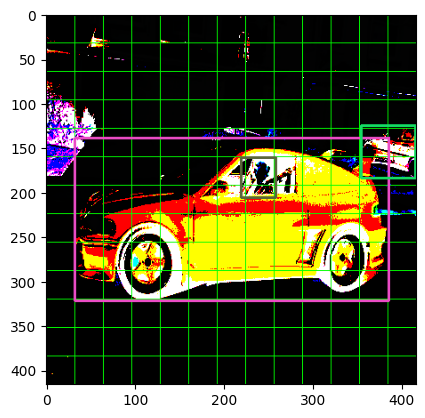

In [99]:
i,_=dataset_2[110]
j=new
img=np.ascontiguousarray(i.permute(1,2,0), dtype=np.uint8)
bbxoes=xywhn2xyxy(j[:,:-1])
img=draw_grid(img)
# plt.figure(figsize=(16,8))
n=0
for l in bbxoes:
  x1,x2=l[0],l[2]
  y1,y2=l[1],l[3]
  z=(np.random.randint(255),np.random.randint(255),np.random.randint(255))
  cv2.rectangle(img,int_(x1,y1),int_(x2,y2),z,2,0)
  # cv2.putText(img,f'{l}',(0,0+n),cv2.FONT_HERSHEY_SIMPLEX,.6,z,2,cv2.LINE_AA)
  n+=20
plt.imshow(img)

In [108]:
him[...,0].reshape(13,13),me[...,0].reshape(13,13)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,